In [1]:
import os
import pickle
from lib.methods import LoadCSV, PreProcessing, EchoStateNetwork, Figure
import warnings
warnings.simplefilter('ignore')

fig = Figure({
            'font.family':'Times New Roman',
            'mathtext.fontset':'stix',
            'font.size':30
            })

In [2]:
os.chdir('../')

In [3]:
FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
DATA_NAME = 'MRI5_NVF1_10mm_1p2mmV_1'
ADDITIONAL_PATH = ''
SAMPLE_SPAN = [150000, 180000]
FILTER_METHOD = 'bandpass_filtering'
BANDPASS_PARAMS = {
                'passband_edge_freq':[90, 200], 
                'stopband_edge_freq':[20, 450], 
                'passband_edge_max_loss':1, 
                'stopband_edge_min_loss':10
                }
ESN_PARAMS = {
            'units':500, 
            'SR':0.5, 
            'input_shape':10, 
            'output_shape':10, 
            'W_in_scale':0.1, 
            'W_res_density':0.1, 
            'leak_rate':1.0, 
            'alpha':0.0005, 
            'seed':0
            }
TRAIN_TEST_DATA_PARAMS = {
                        'n_shift':10,
                        'n_dimension':10,
                        'n_train':5000,
                        'n_predstep':1
                        }
MODEL_DIR = './results/esn_model/'

In [4]:
FILE_DIR = './data/VF_FVF_DATASETS/CSV/'
DATA_NAME = 'MRI5_NVF1_10mm_0p4mmV_1'
ADDITIONAL_PATH = ''
SAMPLE_SPAN = [150000, 180000]
FILTER_METHOD = 'bandpass_filtering'
BANDPASS_PARAMS = {
                'passband_edge_freq':[90, 200], 
                'stopband_edge_freq':[20, 450], 
                'passband_edge_max_loss':1, 
                'stopband_edge_min_loss':10
                }
ESN_PARAMS = {
            'units':500, 
            'SR':1, 
            'input_shape':10, 
            'output_shape':10, 
            'W_in_scale':0.1, 
            'W_res_density':0.1, 
            'leak_rate':1.0, 
            'alpha':0.0005, 
            'seed':0
            }
TRAIN_TEST_DATA_PARAMS = {
                        'n_shift':10,
                        'n_dimension':10,
                        'n_train':5000,
                        'n_predstep':1
                        }
MODEL_DIR = './results/esn_model/'

In [5]:
[t_data, mic_data] = LoadCSV(
                            file_path=FILE_DIR+DATA_NAME+ADDITIONAL_PATH+'.csv',
                            data_name_list=['t', 'mic'],
                            sample_span=[0, None]
                            )

Loading csv data
file path | ./data/VF_FVF_DATASETS/CSV/MRI5_NVF1_10mm_0p4mmV_1.csv
data list | t, mic


In [6]:
preprocess = PreProcessing(data=mic_data, t_data=t_data)
preprocess.filter(method=FILTER_METHOD, params=BANDPASS_PARAMS)
preprocess.cut(span=SAMPLE_SPAN, new_t=False)
preprocess.embed(n_shift=TRAIN_TEST_DATA_PARAMS['n_shift'], n_dimension=TRAIN_TEST_DATA_PARAMS['n_dimension'])
train_X, train_Y, test_X, test_Y = preprocess.train_test_split(
                                                            n_train=TRAIN_TEST_DATA_PARAMS['n_train'], 
                                                            n_predstep=TRAIN_TEST_DATA_PARAMS['n_predstep']
                                                            )
train_t = preprocess.t_data[TRAIN_TEST_DATA_PARAMS['n_predstep']:TRAIN_TEST_DATA_PARAMS['n_predstep']+train_Y.shape[0]]
test_t = preprocess.t_data[TRAIN_TEST_DATA_PARAMS['n_train']+TRAIN_TEST_DATA_PARAMS['n_predstep']:TRAIN_TEST_DATA_PARAMS['n_train']+TRAIN_TEST_DATA_PARAMS['n_predstep']+test_Y.shape[0]]

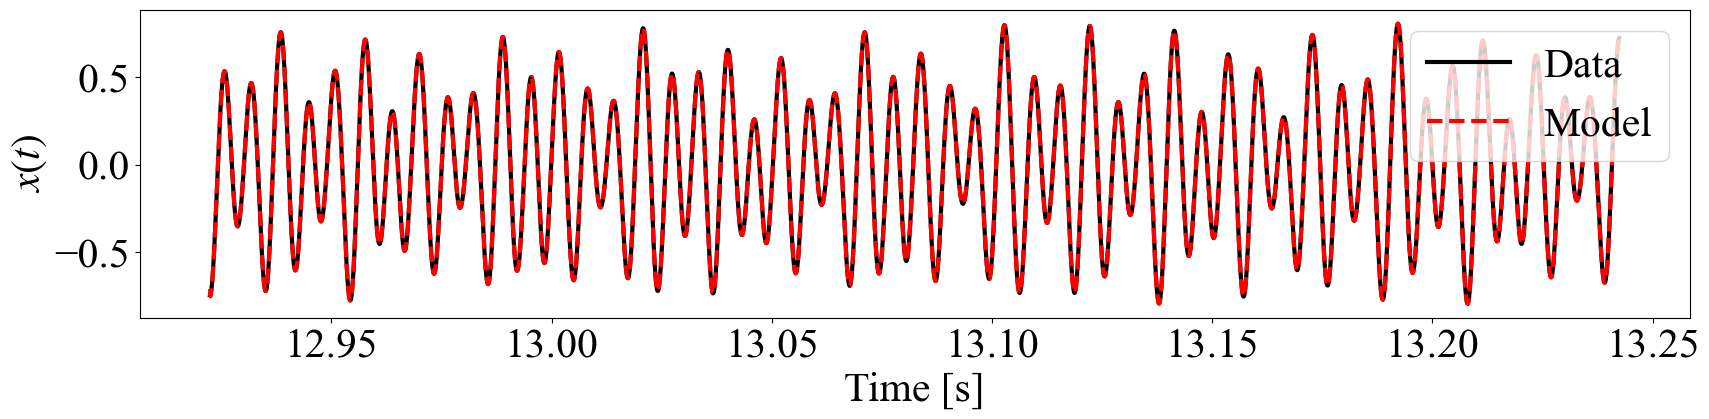

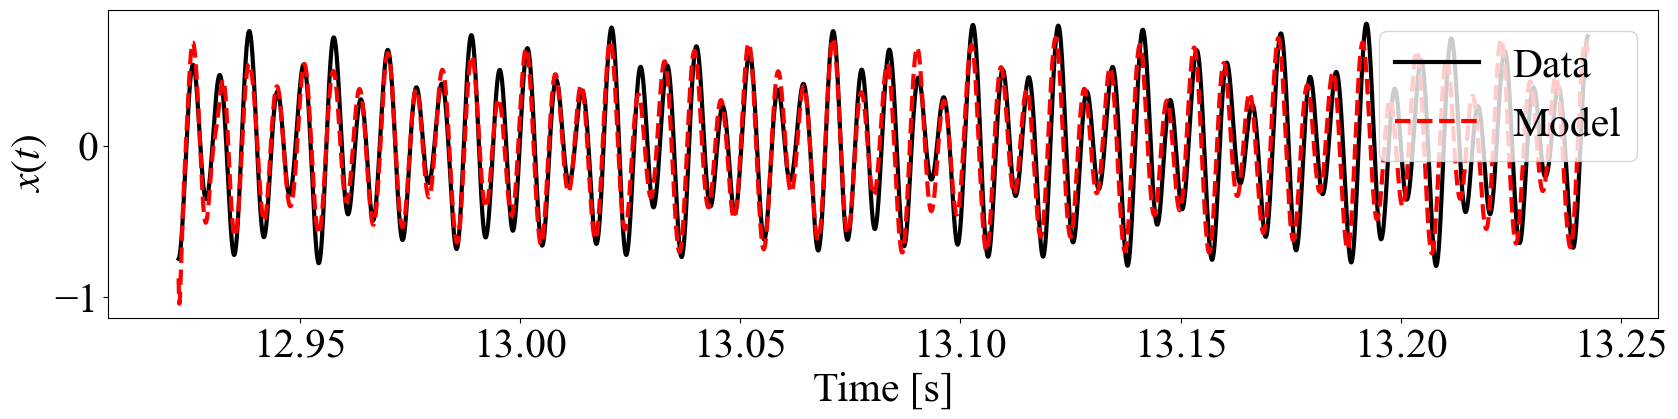

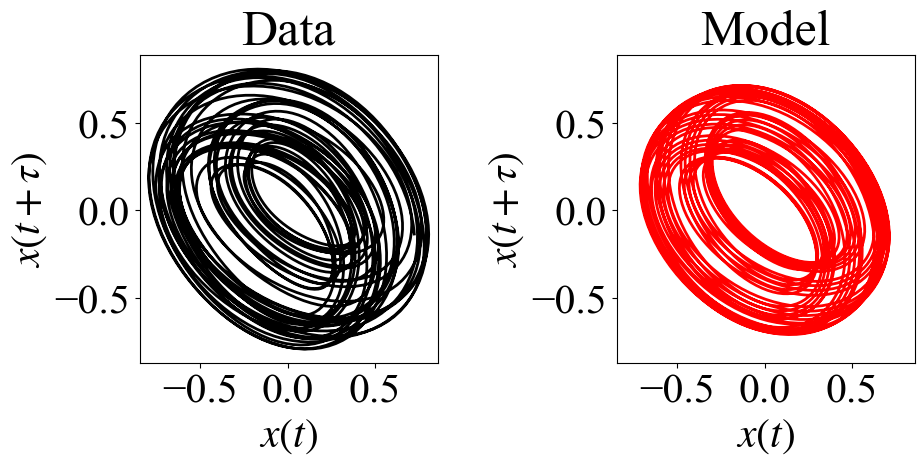

In [7]:
esn = EchoStateNetwork(
                    units=ESN_PARAMS['units'], 
                    SR=ESN_PARAMS['SR'], 
                    input_shape=ESN_PARAMS['input_shape'], 
                    output_shape=ESN_PARAMS['output_shape'], 
                    W_in_scale=ESN_PARAMS['W_in_scale'], 
                    W_res_density=ESN_PARAMS['W_res_density'], 
                    leak_rate=ESN_PARAMS['leak_rate'], 
                    alpha=ESN_PARAMS['alpha'], 
                    seed=ESN_PARAMS['seed']
                    )

esn.fit(in_layer_data=train_X, out_layer_data=train_Y)

pred_test_Y = esn.predict(test_X)
fig.plt_timeseries_of_data_and_model(test_Y[:, 0, 0], pred_test_Y[:, 0], test_t, 4000)

n_freerun = 5000
freerun_test_Y = esn.freerun(in_layer_data0=test_X[0], pred_range=n_freerun, return_reservoir=False)
fig.plt_timeseries_of_data_and_model(test_Y[:, 0, 0], freerun_test_Y[:, 0], test_t, 4000)
fig.plt_attractor_of_data_and_model(test_Y[1000:, 0, 0], freerun_test_Y[1000:, 0], 3000, 25)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

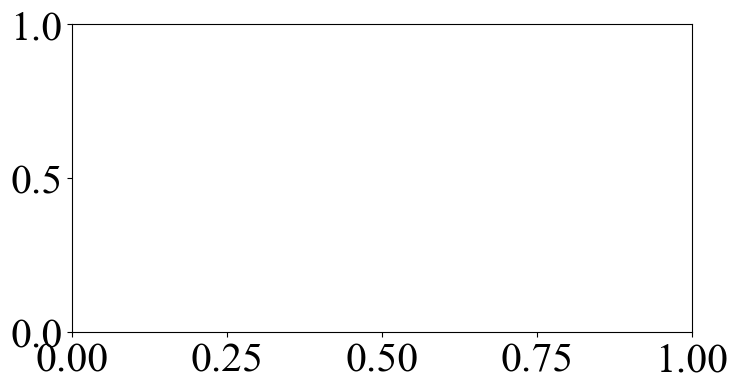

In [8]:
lyapunov_exponents, dims = esn.computing_lyapunov_exponent(dt=t_data[1]-t_data[0])
fig.plt_lyapunov_exponents(lyapunov_exponents)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

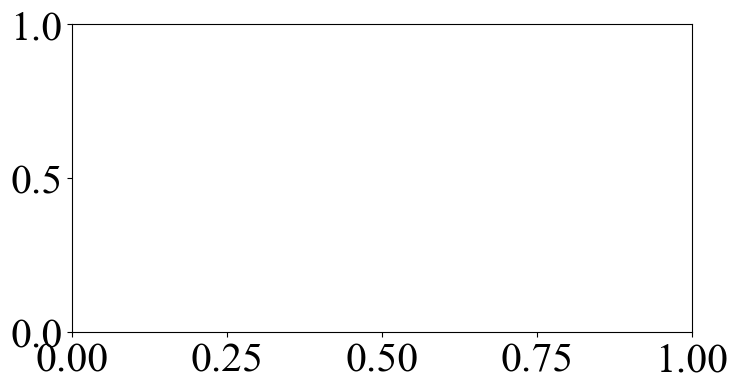

In [26]:
fig.plt_lyapunov_exponents(lyapunov_exponents)

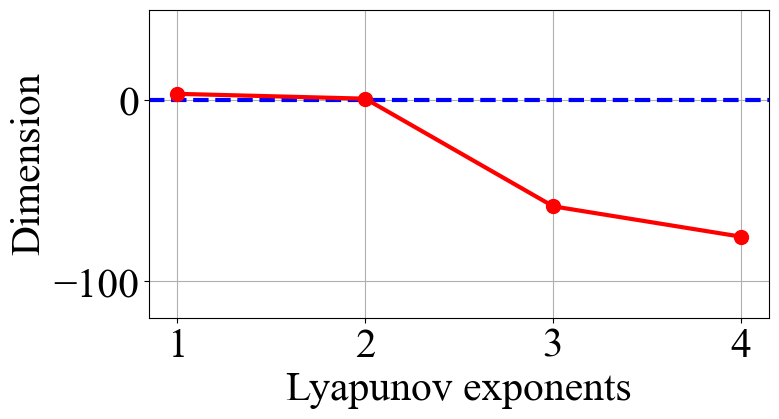

In [9]:
import numpy as np
import tqdm
import matplotlib.pylab as plt
from matplotlib import gridspec

def plt_lyapunov_exponents( 
                               lyapunov_exponents, 
                               n_dim=4,
                               lyapunov_lim=(-120, 50), 
                               params={
                                    'figsize':(8, 4),
                                    'linestyle_0line':'dashed',
                                    'c_0line':'b',
                                    'lw_0line':3,
                                    'linestyle_model':'-',
                                    'marker_model':'o',
                                    'markersize_model':10,
                                    'c_model':'r',
                                    'lw_model':3,
                                    'xlabel':'Lyapunov exponents',
                                    'ylabel':'Dimension'
                               }
                               ):
        fig = plt.figure(figsize=params['figsize'])
        ax = fig.add_subplot(111)
        plt.axhline(y=0, xmin=0, xmax=n_dim+1, linestyle=params['linestyle_0line'], c=params['c_0line'], lw=params['lw_0line'])
        ax.plot(np.arange(1, n_dim+1), lyapunov_exponents[:n_dim], linestyle=params['linestyle_model'], c=params['c_model'], 
                lw=params['lw_model'], marker=params['marker_model'], markersize=params['markersize_model'])
        ax.grid()
        ax.set_ylim(lyapunov_lim)
        ax.set_xlabel(params['xlabel'])
        ax.set_ylabel(params['ylabel'])
        plt.show()

plt_lyapunov_exponents(lyapunov_exponents)

In [19]:
pickle.dump(esn, open(MODEL_DIR+DATA_NAME+'.pkl', "wb"))